# Analyzing Hierarchical NB model with molecular covariates on larger-subsample dataset

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
from collections import Counter
from itertools import product
from time import time
from typing import Final

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc as pm
import seaborn as sns

In [3]:
from speclet.analysis.arviz_analysis import extract_matrix_variable_coords
from speclet.bayesian_models.hierarchical_nb import HierarchcalNegativeBinomialModel
from speclet.data_processing.vectors import squish_array
from speclet.io import DataFile, models_dir
from speclet.managers.data_managers import CrisprScreenDataManager
from speclet.plot.plotnine_helpers import set_gg_theme
from speclet.project_configuration import read_project_configuration

In [4]:
# Notebook execution timer.
notebook_tic = time()

# Plotting setup.
set_gg_theme()
%config InlineBackend.figure_format = "retina"

# Constants
RANDOM_SEED = 847
np.random.seed(RANDOM_SEED)
HDI_PROB = read_project_configuration().modeling.highest_density_interval

In [5]:
model_res_dir = models_dir() / "hnb-copynum-rna-mut-covariates_PYMC_MCMC"

In [6]:
lineage_pal: Final[dict[str, str]] = {"bone": "darkviolet", "colorectal": "green"}

## Data

In [7]:
counts_dm = CrisprScreenDataManager(DataFile.DEPMAP_CRC_BONE_LARGE_SUBSAMPLE)
counts_data = counts_dm.get_data()
counts_data.head()

/Users/admin/Developer/haigis-lab/speclet/speclet/managers/data_managers.py:139: DtypeWarning: Columns (3,22) have mixed types. Specify dtype option on import or set low_memory=False.


,sgrna,replicate_id,lfc,p_dna_batch,genome_alignment,hugo_symbol,screen,multiple_hits_on_gene,sgrna_target_chr,sgrna_target_pos,...,num_mutations,any_deleterious,any_tcga_hotspot,any_cosmic_hotspot,is_mutated,copy_number,lineage,primary_or_metastasis,is_male,age
0,AAAGCCCAGGAGTATGGGAG,LS513-311Cas9_RepA_p6_batch2,0.594321,2,chr2_130522105_-,CFC1B,broad,True,2,130522105,...,0,NaN,NaN,NaN,False,0.951337,colorectal,primary,True,63.0
1,AATCGGAATGGTCTCGCTC,LS513_c903R1,-0.272724,ERS717283.plasmid,chr6_81751906_+,TENT5A,sanger,True,6,81751906,...,0,NaN,NaN,NaN,False,0.949854,colorectal,primary,True,63.0
2,ACGCCACTGACACTCAAGG,LS513_c903R1,0.583209,ERS717283.plasmid,chr1_27006713_-,TENT5B,sanger,True,1,27006713,...,0,NaN,NaN,NaN,False,0.961139,colorectal,primary,True,63.0
3,ACTTGTCTCATGAACGTGAT,LS513-311Cas9_RepA_p6_batch2,0.475678,2,chr2_86917638_+,RGPD1,broad,True,2,86917638,...,0,NaN,NaN,NaN,False,0.949234,colorectal,primary,True,63.0
4,AGAAACTTCACCCCTTTCAT,LS513-311Cas9_RepA_p6_batch2,0.296108,2,chr16_18543661_+,NOMO2,broad,True,16,18543661,...,0,NaN,NaN,NaN,False,0.944648,colorectal,primary,True,63.0


## Model

### Description

In [8]:
hnb = HierarchcalNegativeBinomialModel()

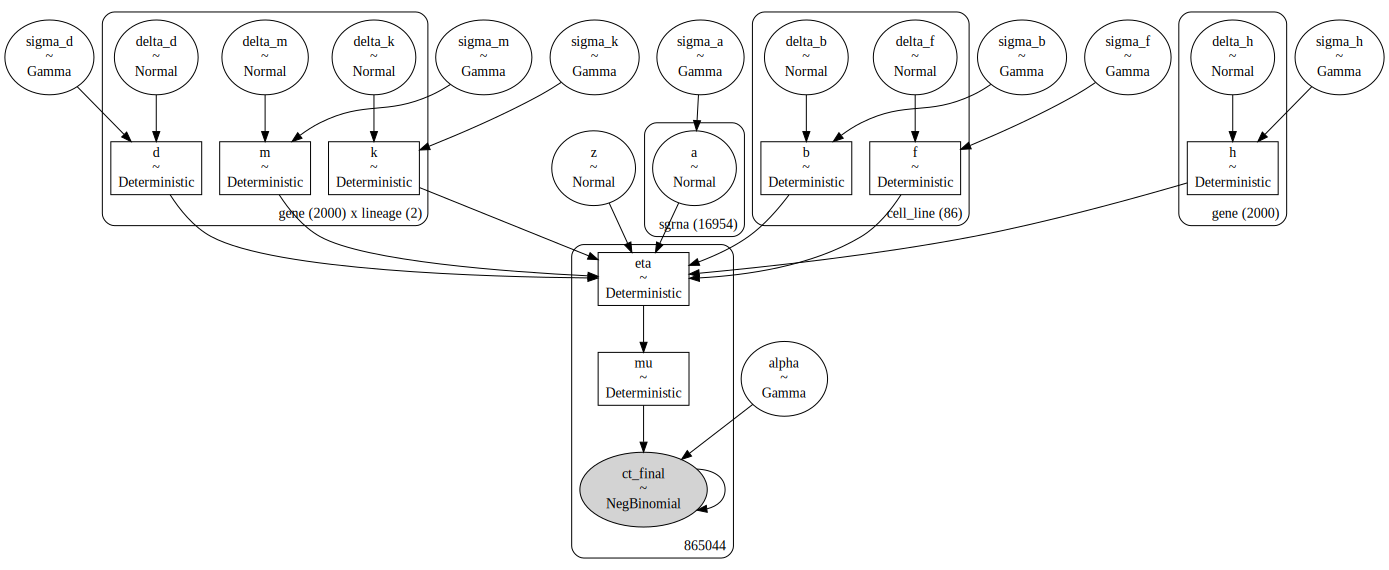

In [9]:
hnb_model = hnb.pymc_model(counts_data)
pm.model_to_graphviz(hnb_model)

In [10]:
with open(model_res_dir / "description.txt") as file:
    description = "".join(list(file))
print(description)

name: 'hnb-copynum-rna-mut-covariates'
fit method: 'PYMC_MCMC'

--------------------------------------------------------------------------------

CONFIGURATION

{
    "name": "hnb-copynum-rna-mut-covariates",
    "description": " A hierarchical negative binomial model with copy number, RNA expression, and mutation status covariates.. ",
    "active": true,
    "model": "HIERARCHICAL_NB",
    "data_file": "DEPMAP_CRC_BONE_LARGE_SUBSAMPLE",
    "subsample": false,
    "sampling_kwargs": {
        "stan_mcmc": null,
        "pymc_mcmc": {
            "draws": 1000,
            "init": "adapt_diag",
            "step": null,
            "n_init": 200000,
            "chain_idx": 0,
            "chains": null,
            "cores": null,
            "tune": 1000,
            "progressbar": true,
            "discard_tuned_samples": true,
            "compute_convergence_checks": true,
            "return_inferencedata": true,
            "idata_kwargs": null,
            "target_accept": 0.9

### Load posterior results

In [11]:
valid_counts_data = hnb.data_processing_pipeline(counts_data)

In [12]:
hnb_post_summary = pd.read_csv(model_res_dir / "posterior-summary.csv").assign(
    param_name=lambda d: [x.split("[")[0] for x in d.parameter]
)
hnb_post_summary.head()

,parameter,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,param_name
0,z,0.038,0.006,0.029,0.048,0.000,0.000,2571.0,2132.0,1.0,z
1,a[AAAGCCCAGGAGTATGGGAG],0.202,0.110,0.018,0.365,0.002,0.001,4100.0,2461.0,1.0,a
2,a[ACTTGTCTCATGAACGTGAT],0.136,0.126,-0.082,0.319,0.002,0.002,2969.0,1639.0,1.0,a
3,a[AGAAACTTCACCCCTTTCAT],0.254,0.108,0.075,0.423,0.002,0.001,4285.0,2281.0,1.0,a
4,a[AGCTGAGCGCAGGGACCGGG],-0.112,0.108,-0.292,0.049,0.002,0.002,3775.0,2272.0,1.0,a


In [13]:
hnb_post_pred = pd.read_csv(model_res_dir / "posterior-predictions.csv")
hnb_post_pred.head()

,chain,draw,ct_final_dim_0,ct_final
0,0,0,0,659
1,0,0,1,947
2,0,0,2,1453
3,0,0,3,183
4,0,0,4,946


## Posterior Analysis

### Model parameters

In [14]:
hnb_post_summary[["ess_bulk", "ess_tail", "r_hat"]].describe()

,ess_bulk,ess_tail,r_hat
count,31135.000000,31135.000000,31135.000000
mean,4217.500723,2178.167625,1.000143
std,960.268326,329.774559,0.001187
min,496.000000,958.000000,1.000000
25%,3169.000000,1916.000000,1.000000
50%,4425.000000,2236.000000,1.000000
75%,4932.000000,2436.000000,1.000000
max,8172.000000,3117.000000,1.010000


In [15]:
d1_vars = [p for p, v in Counter(hnb_post_summary.param_name.values).items() if v == 1]  # type: ignore
sd_vars = [p for p in d1_vars if "sigma" in p]

In [16]:
post_y_lbl = f"posterior distribution\n(mean ± {100*HDI_PROB:0.0f}% HDI)"

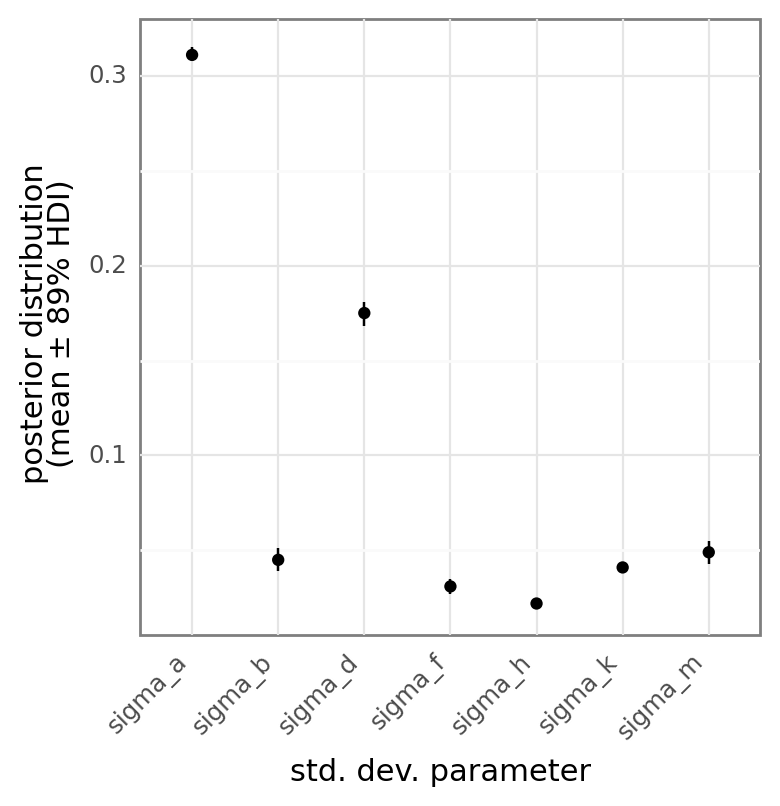

<ggplot: (350116359)>

In [17]:
(
    gg.ggplot(
        hnb_post_summary.filter_column_isin("param_name", sd_vars),
        gg.aes(x="parameter", y="mean"),
    )
    + gg.geom_linerange(gg.aes(ymin="hdi_5.5%", ymax="hdi_94.5%"))
    + gg.geom_point()
    + gg.theme(axis_text_x=gg.element_text(angle=45, hjust=1))
    + gg.labs(x="std. dev. parameter", y=post_y_lbl)
)

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


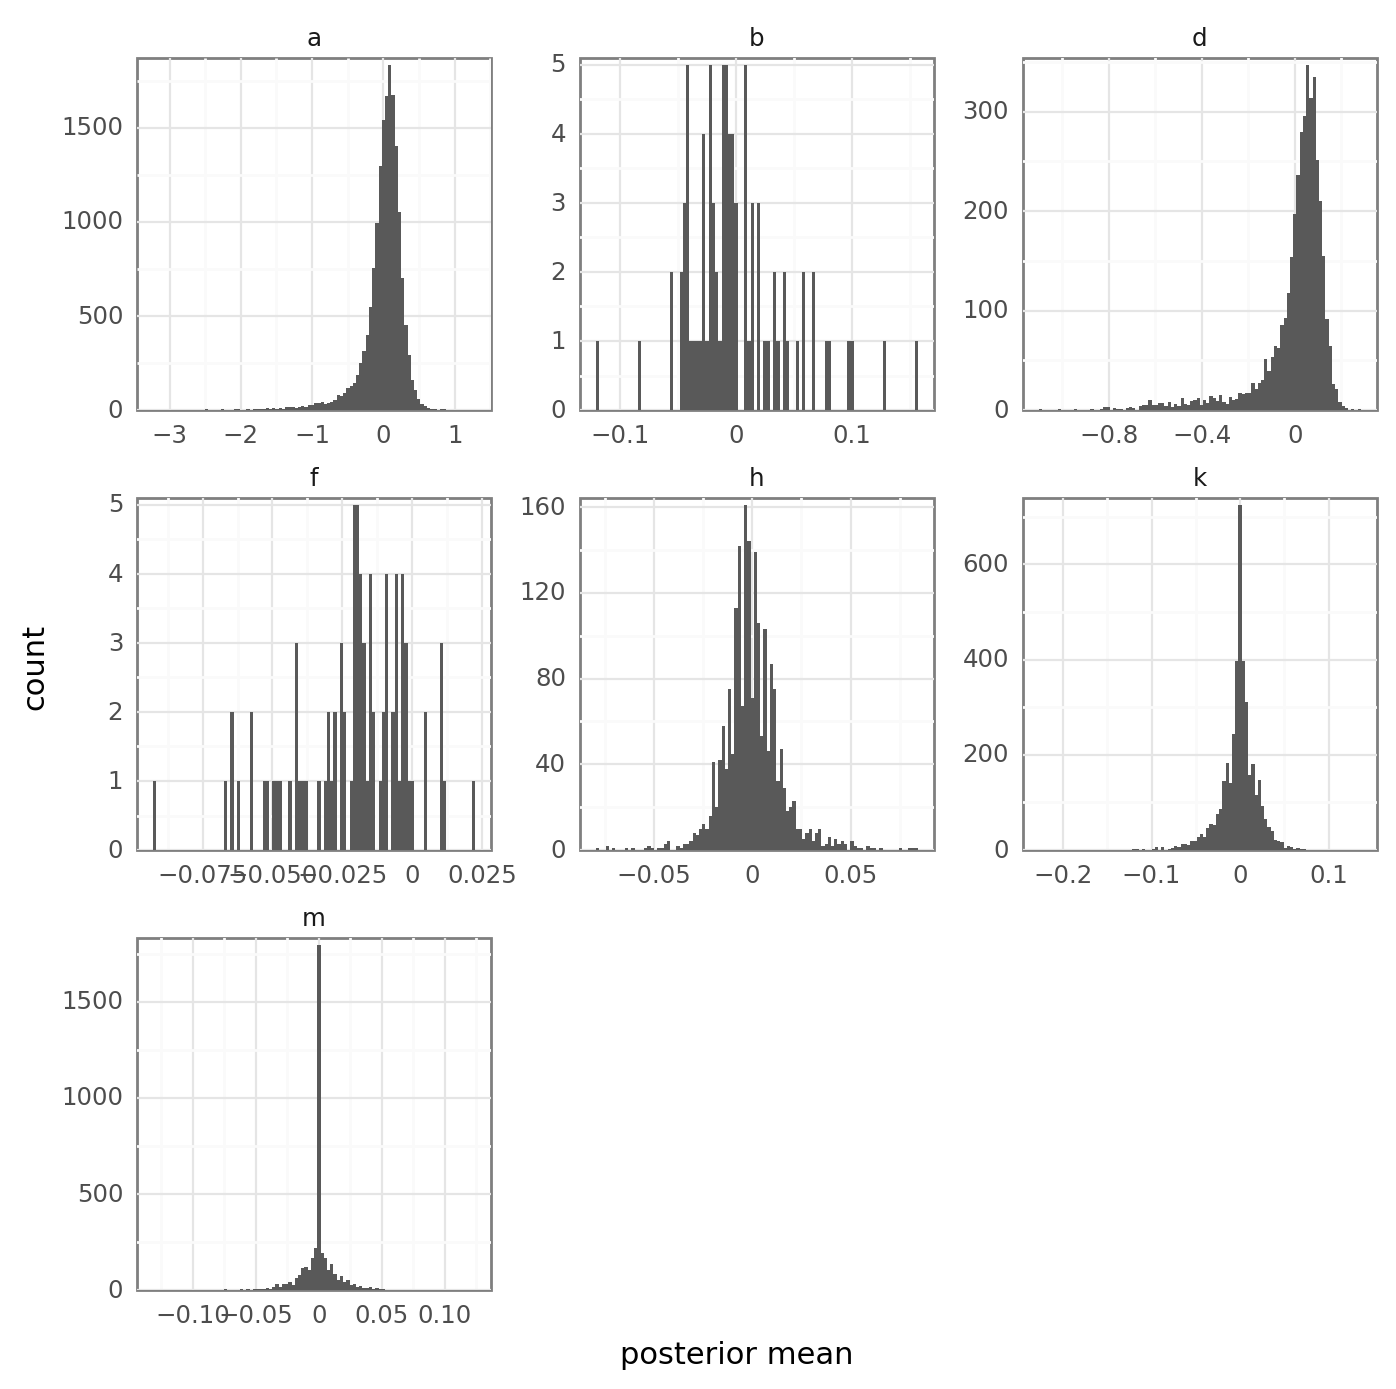

<ggplot: (351088978)>

In [18]:
(
    gg.ggplot(
        hnb_post_summary.filter_column_isin("param_name", d1_vars, complement=True),
        gg.aes(x="mean"),
    )
    + gg.facet_wrap("~ param_name", scales="free")
    + gg.geom_histogram(bins=100)
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    + gg.theme(
        figure_size=(8, 8),
        subplots_adjust={"wspace": 0.25, "hspace": 0.25},
    )
    + gg.labs(x="posterior mean")
)

In [19]:
cellline_to_lineage = (
    valid_counts_data[["depmap_id", "lineage"]].drop_duplicates().reset_index()
)

cellline_post = (
    hnb_post_summary.query("param_name == 'b'")
    .reset_index(drop=True)
    .assign(
        depmap_id=lambda d: [re.findall(r"(?<=\[).+(?=\])", x)[0] for x in d.parameter]
    )
    .merge(cellline_to_lineage, on="depmap_id")
    .sort_values(["lineage", "mean"])
    .assign(
        depmap_id=lambda d: pd.Categorical(
            d.depmap_id, categories=d.depmap_id, ordered=True
        )
    )
)

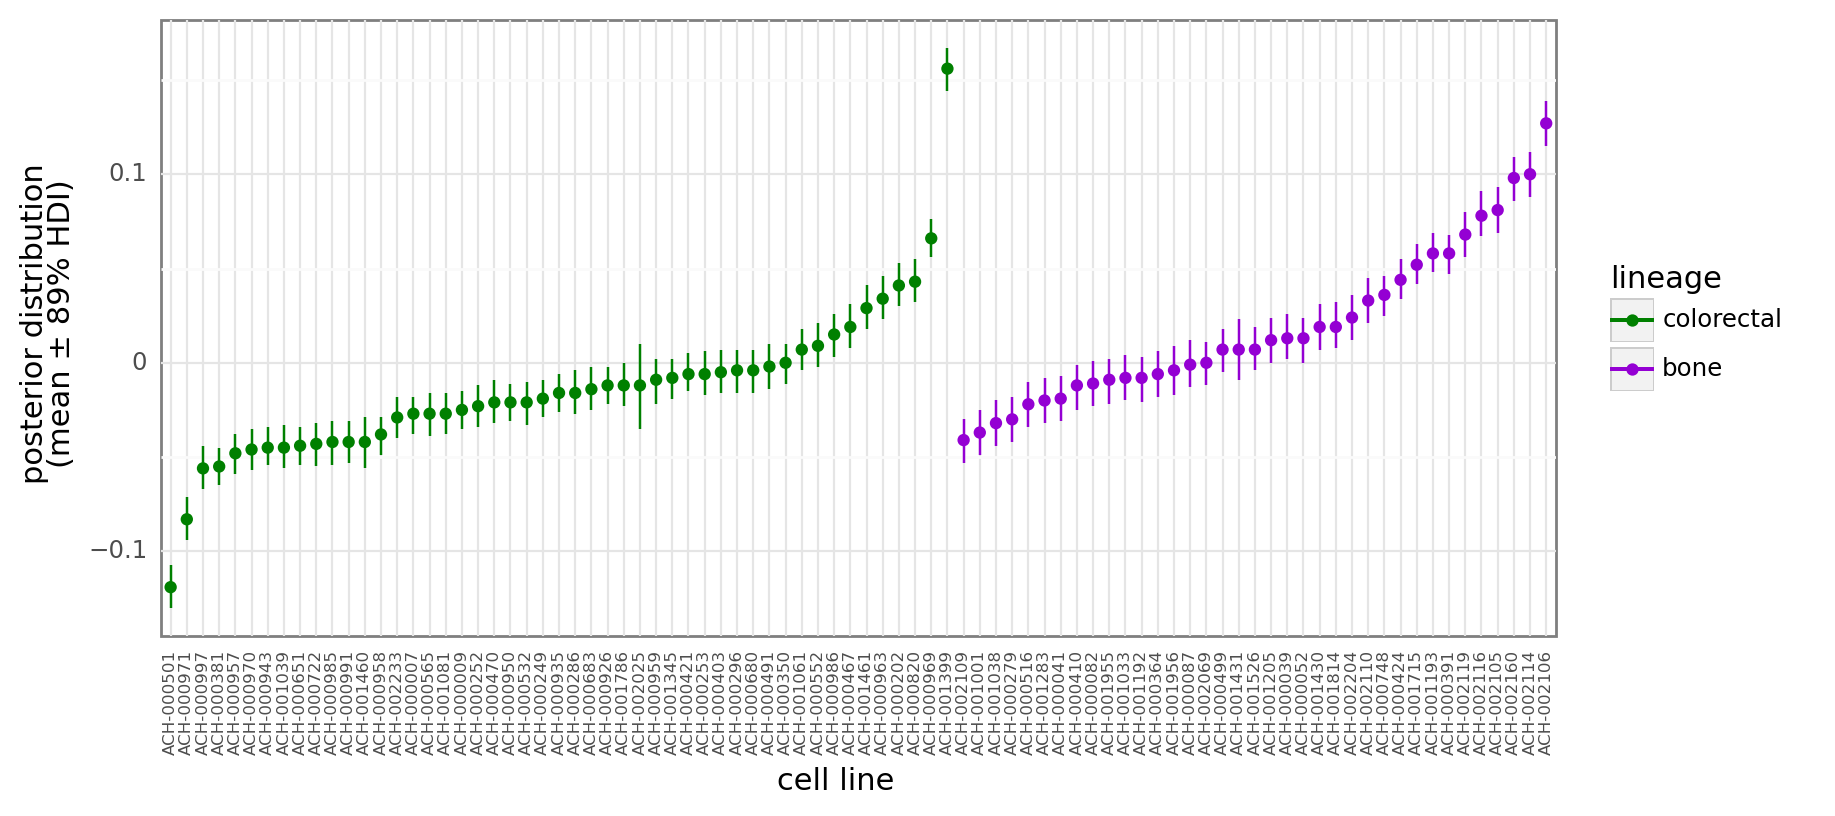

<ggplot: (348719894)>

In [20]:
(
    gg.ggplot(cellline_post, gg.aes(x="depmap_id", y="mean"))
    + gg.geom_linerange(gg.aes(ymin="hdi_5.5%", ymax="hdi_94.5%", color="lineage"))
    + gg.geom_point(gg.aes(color="lineage"))
    + gg.scale_color_manual(lineage_pal)
    + gg.theme(axis_text_x=gg.element_text(angle=90, size=6), figure_size=(9, 4))
    + gg.labs(x="cell line", y=post_y_lbl)
)

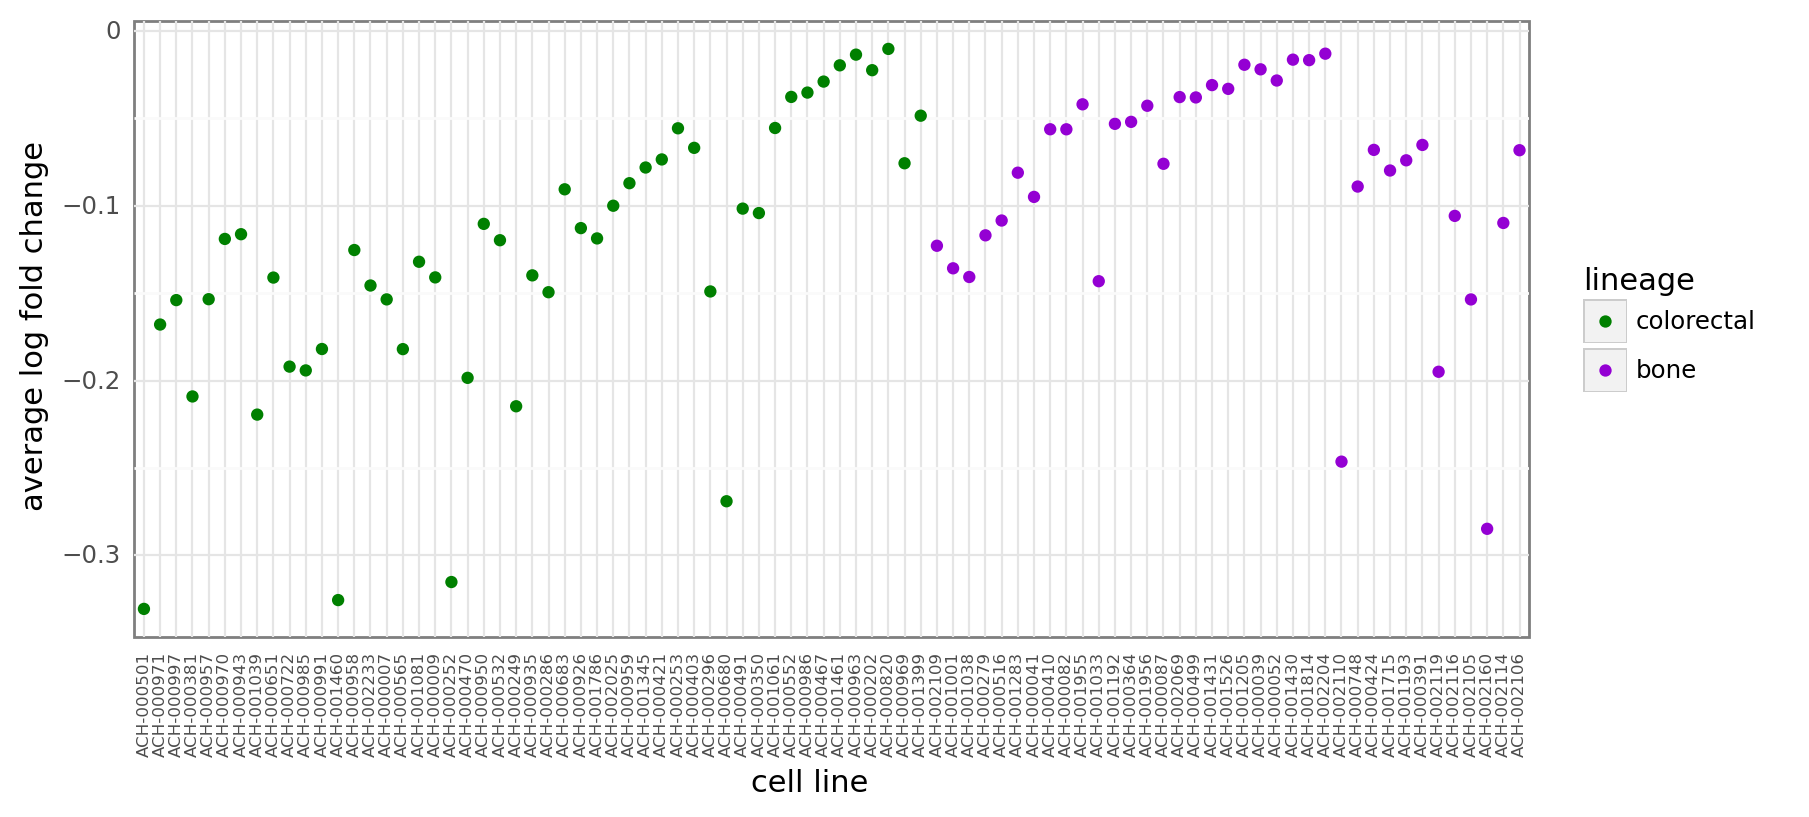

<ggplot: (350291228)>

In [21]:
cellline_lfc_avg = (
    valid_counts_data.groupby(["depmap_id", "lineage"])["lfc"]
    .mean()
    .reset_index(drop=False)
    .dropna()
    .assign(
        depmap_id=lambda d: pd.Categorical(
            d.depmap_id.values,
            categories=cellline_post.depmap_id.cat.categories,
            ordered=True,
        )
    )
)
(
    gg.ggplot(cellline_lfc_avg, gg.aes(x="depmap_id", y="lfc"))
    + gg.geom_point(gg.aes(color="lineage"))
    + gg.scale_color_manual(lineage_pal)
    + gg.theme(axis_text_x=gg.element_text(angle=90, size=6), figure_size=(9, 4))
    + gg.labs(x="cell line", y="average log fold change")
)

In [22]:
d_post = (
    hnb_post_summary.query("param_name == 'd'")
    .reset_index(drop=True)
    .pipe(
        extract_matrix_variable_coords,
        col="parameter",
        idx1name="hugo_symbol",
        idx2name="lineage",
    )
)

In [23]:
d_post_wide = d_post.pivot_wider(
    index=["hugo_symbol"], names_from="lineage", values_from="mean"
)
d_post_wide.head()

,hugo_symbol,bone,colorectal
0,A1BG,0.041,0.099
1,AAK1,0.034,0.074
2,AAR2,0.009,0.029
3,ABAT,0.038,0.089
4,ABCA1,0.103,0.090


In [24]:
goi = []
_queries = [
    "bone > 0 and colorectal < -0.4",
    "bone > 0.1 and colorectal < -0.25",
    "colorectal < -1.01",
    "colorectal > 0.1 and bone < -0.2",
    "bone < colorectal and colorectal < -0.55 and bone < -0.7",
    "bone < colorectal and -0.2 < colorectal < -0.1 and bone < -0.5",
]
for q in _queries:
    goi += d_post_wide.query(q).hugo_symbol.tolist()
goi = list(set(goi))

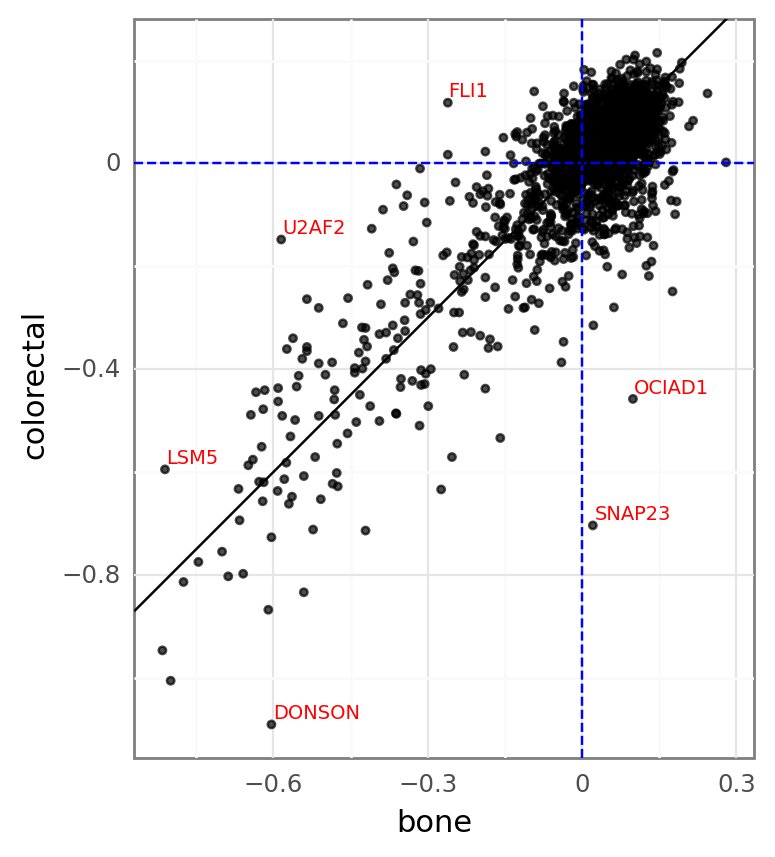

<ggplot: (351000905)>

In [25]:
(
    gg.ggplot(d_post_wide, gg.aes(x="bone", y="colorectal"))
    + gg.geom_point(alpha=0.7, size=1)
    + gg.geom_hline(yintercept=0, linetype="--", color="blue")
    + gg.geom_vline(xintercept=0, linetype="--", color="blue")
    + gg.geom_abline(slope=1, intercept=0)
    + gg.geom_text(
        gg.aes(label="hugo_symbol"),
        data=d_post_wide.filter_column_isin("hugo_symbol", goi),
        size=7,
        color="red",
        adjust_text={"ha": "center"},
    )
    + gg.coord_equal()
)

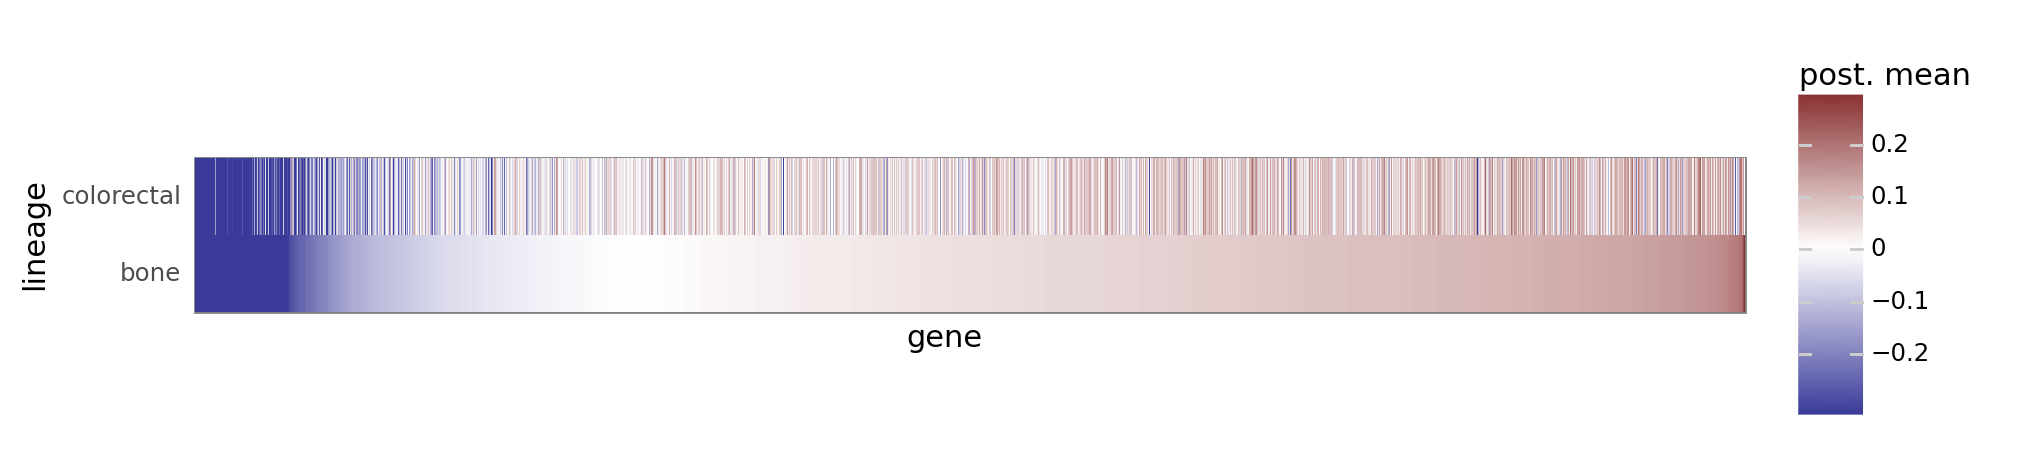

<ggplot: (347569908)>

In [26]:
plt_df = (
    d_post.copy()
    .sort_values(["lineage", "mean"])
    .assign(
        mean=lambda d: squish_array(d["mean"], lower=-0.3, upper=0.3),
        hugo_symbol=lambda d: pd.Categorical(
            d.hugo_symbol, categories=d.hugo_symbol.unique(), ordered=True
        ),
    )
)
(
    gg.ggplot(plt_df, gg.aes(x="hugo_symbol", y="lineage"))
    + gg.geom_tile(gg.aes(fill="mean"), color=None)
    + gg.scale_x_discrete(expand=(0, 0.5))
    + gg.scale_y_discrete(expand=(0, 0.5))
    + gg.scale_fill_gradient2(low="#3A3A98", high="#832424")
    + gg.theme(
        axis_text_x=gg.element_blank(),
        panel_grid=gg.element_blank(),
        figure_size=(10, 1),
    )
    + gg.labs(x="gene", y="lineage", fill="post. mean")
)

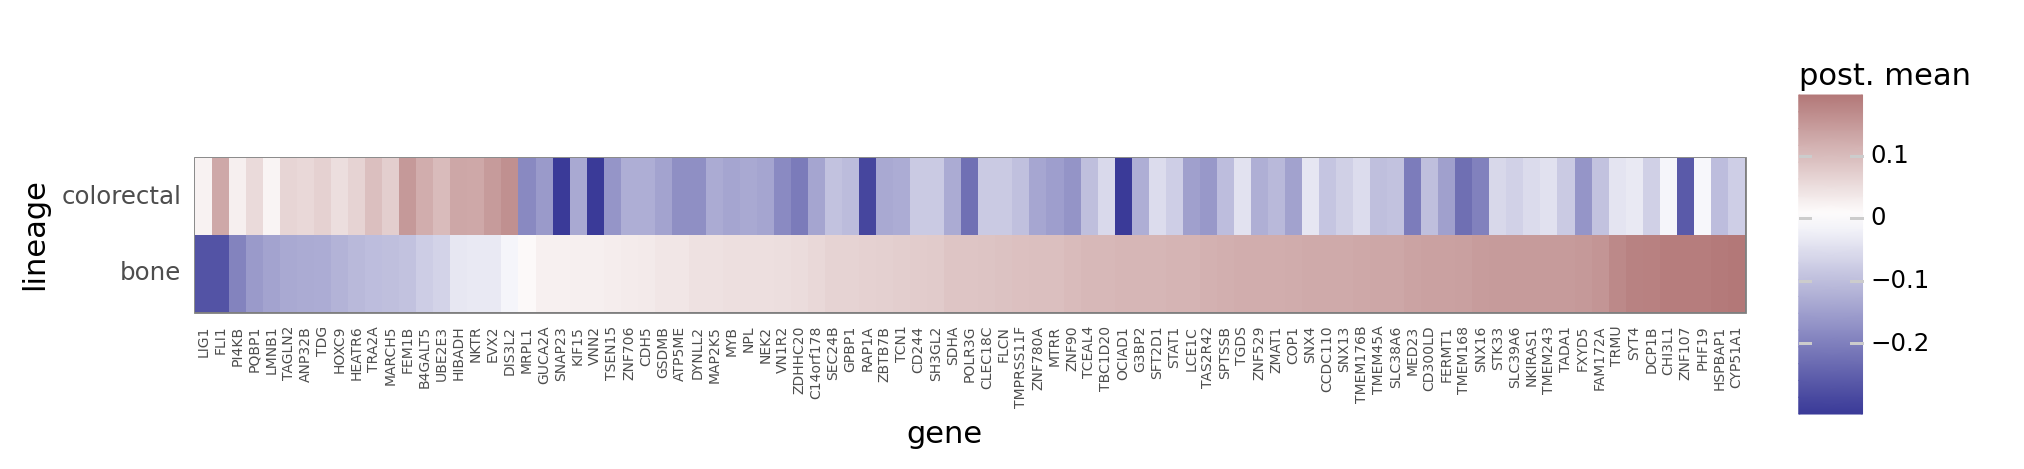

<ggplot: (352391153)>

In [27]:
plt_df = (
    d_post.copy()
    .filter_column_isin(
        "hugo_symbol",
        d_post_wide.query(
            "bone * colorectal < 0 and abs(bone - colorectal) > 0.15"
        ).hugo_symbol,
    )
    .sort_values(["lineage", "mean"])
    .assign(
        mean=lambda d: squish_array(d["mean"], lower=-0.3, upper=0.3),
        hugo_symbol=lambda d: pd.Categorical(
            d.hugo_symbol, categories=d.hugo_symbol.unique(), ordered=True
        ),
    )
)
(
    gg.ggplot(plt_df, gg.aes(x="hugo_symbol", y="lineage"))
    + gg.geom_tile(gg.aes(fill="mean"), color=None)
    + gg.scale_x_discrete(expand=(0, 0.5))
    + gg.scale_y_discrete(expand=(0, 0.5))
    + gg.scale_fill_gradient2(low="#3A3A98", high="#832424")
    + gg.theme(
        axis_text_x=gg.element_text(angle=90, size=5),
        panel_grid=gg.element_blank(),
        figure_size=(10, 1),
    )
    + gg.labs(x="gene", y="lineage", fill="post. mean")
)

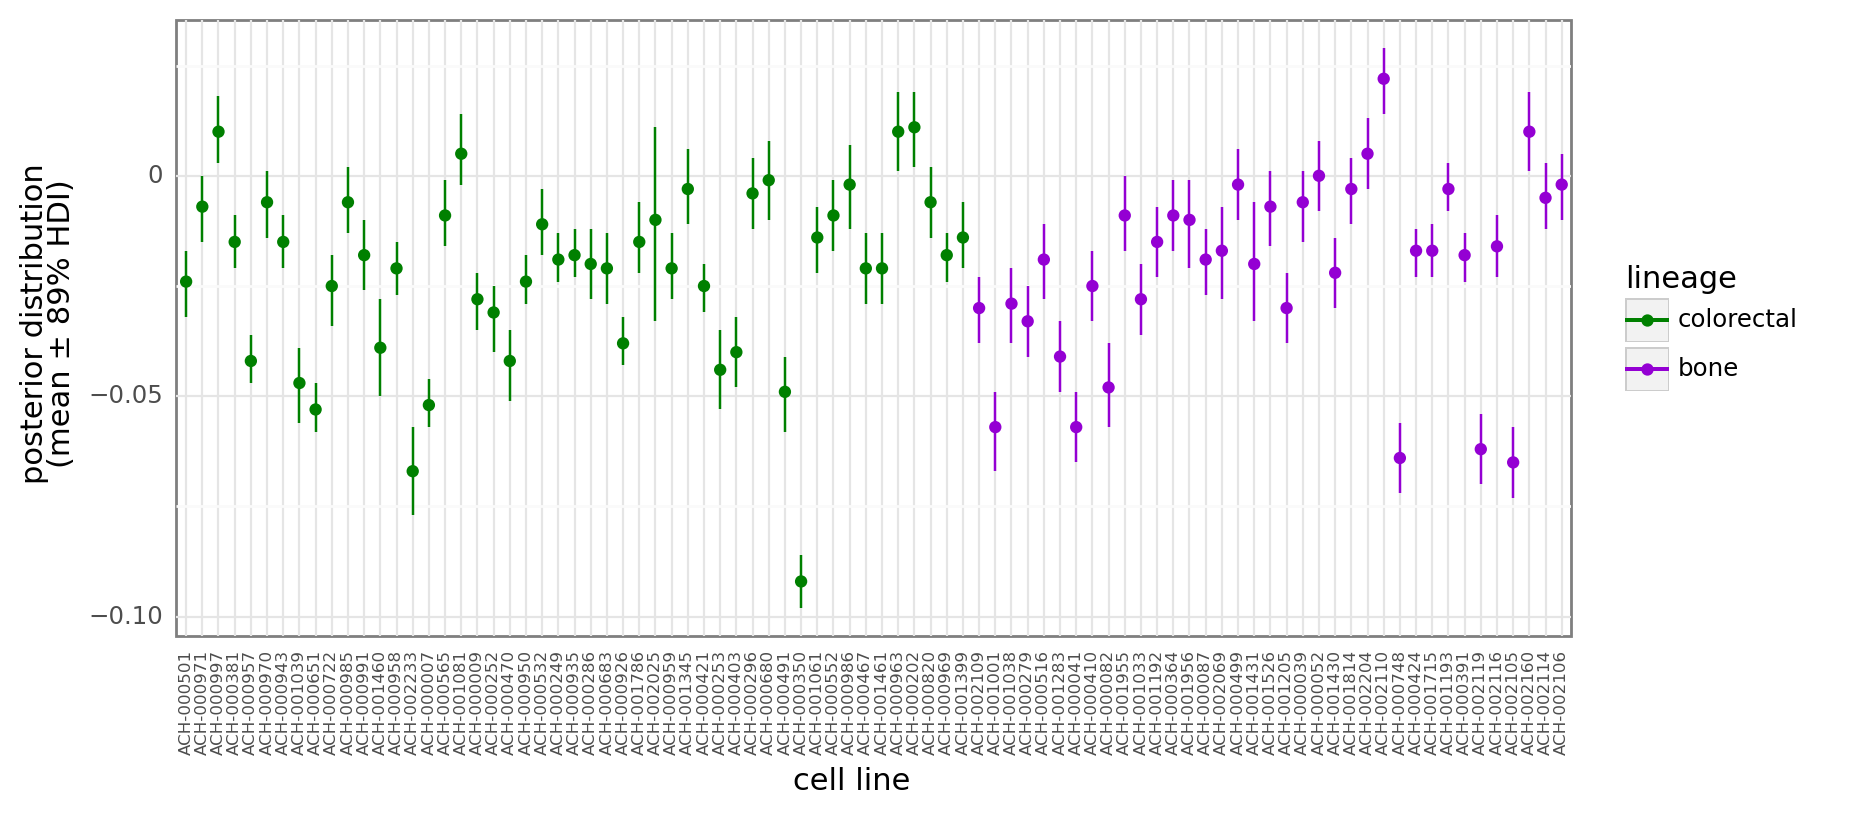

<ggplot: (347574751)>

In [28]:
f_post = (
    hnb_post_summary.query("param_name == 'f'")
    .reset_index(drop=True)
    .assign(
        depmap_id=lambda d: [re.findall(r"(?<=\[).+(?=\])", x)[0] for x in d.parameter]
    )
    .merge(cellline_to_lineage, on="depmap_id")
    .assign(
        depmap_id=lambda d: pd.Categorical(
            d.depmap_id, categories=cellline_post.depmap_id.cat.categories, ordered=True
        )
    )
)

(
    gg.ggplot(f_post, gg.aes(x="depmap_id", y="mean"))
    + gg.geom_linerange(gg.aes(ymin="hdi_5.5%", ymax="hdi_94.5%", color="lineage"))
    + gg.geom_point(gg.aes(color="lineage"))
    + gg.scale_color_manual(lineage_pal)
    + gg.theme(axis_text_x=gg.element_text(angle=90, size=6), figure_size=(9, 4))
    + gg.labs(x="cell line", y=post_y_lbl)
)

In [29]:
m_post = (
    hnb_post_summary.query("param_name == 'm'")
    .reset_index(drop=True)
    .pipe(
        extract_matrix_variable_coords,
        col="parameter",
        idx1name="hugo_symbol",
        idx2name="lineage",
    )
)
m_post_nonzero_hdi = m_post.query(
    "`hdi_5.5%` * mean > 0 and `hdi_94.5%` * mean > 0"
).sort_values("mean")
m_post_nonzero_hdi

,parameter,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,param_name,hugo_symbol,lineage
902,"m[SCFD1, colorectal]",-0.131,0.042,-0.196,-0.061,0.001,0.001,2909.0,2036.0,1.0,m,SCFD1,colorectal
3872,"m[KIF18A, colorectal]",-0.130,0.043,-0.204,-0.069,0.001,0.001,2380.0,2263.0,1.0,m,KIF18A,colorectal
878,"m[DDX18, colorectal]",-0.097,0.042,-0.164,-0.031,0.001,0.001,2779.0,1859.0,1.0,m,DDX18,colorectal
1430,"m[SAP130, colorectal]",-0.088,0.043,-0.156,-0.020,0.001,0.001,2940.0,2126.0,1.0,m,SAP130,colorectal
3246,"m[HEATR1, colorectal]",-0.079,0.041,-0.142,-0.013,0.001,0.001,2632.0,1480.0,1.0,m,HEATR1,colorectal
1300,"m[SLC3A2, colorectal]",-0.075,0.044,-0.143,-0.003,0.001,0.001,2947.0,1813.0,1.0,m,SLC3A2,colorectal
3240,"m[MGA, colorectal]",-0.075,0.038,-0.140,-0.016,0.001,0.001,2954.0,1889.0,1.0,m,MGA,colorectal
120,"m[SAMM50, colorectal]",-0.074,0.045,-0.147,-0.006,0.001,0.001,2734.0,1715.0,1.0,m,SAMM50,colorectal
764,"m[MCM7, colorectal]",-0.073,0.044,-0.144,-0.004,0.001,0.001,3013.0,1858.0,1.0,m,MCM7,colorectal
2134,"m[ANAPC1, colorectal]",-0.072,0.039,-0.135,-0.011,0.001,0.001,2938.0,1674.0,1.0,m,ANAPC1,colorectal


In [30]:
k_post = (
    hnb_post_summary.query("param_name == 'k'")
    .reset_index(drop=True)
    .pipe(
        extract_matrix_variable_coords,
        col="parameter",
        idx1name="hugo_symbol",
        idx2name="lineage",
    )
)
k_post.query("`hdi_5.5%` * mean > 0 and `hdi_94.5%` * mean > 0").sort_values(
    "mean"
).head()

,parameter,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,param_name,hugo_symbol,lineage
1706,"k[U2AF2, colorectal]",-0.225,0.032,-0.273,-0.172,0.001,0.0,3133.0,1922.0,1.0,k,U2AF2,colorectal
2844,"k[RIOK1, colorectal]",-0.157,0.034,-0.212,-0.105,0.001,0.0,2840.0,2270.0,1.0,k,RIOK1,colorectal
1112,"k[GNL3, colorectal]",-0.120,0.031,-0.169,-0.071,0.001,0.0,2807.0,1900.0,1.0,k,GNL3,colorectal
1928,"k[SNRNP40, colorectal]",-0.119,0.032,-0.170,-0.069,0.001,0.0,2913.0,1950.0,1.0,k,SNRNP40,colorectal
1166,"k[POMP, colorectal]",-0.118,0.032,-0.171,-0.070,0.001,0.0,2972.0,2025.0,1.0,k,POMP,colorectal


In [31]:
h_post = (
    hnb_post_summary.query("param_name == 'h'")
    .reset_index(drop=True)
    .assign(
        hugo_symbol=lambda d: [
            re.findall(r"(?<=\[).*(?=\])", x)[0] for x in d.parameter
        ]
    )
)

In [32]:
gene_var_post = pd.concat(
    [
        (
            hnb_post_summary.filter_column_isin("param_name", list("dkm"))
            .reset_index(drop=True)
            .pipe(
                extract_matrix_variable_coords,
                col="parameter",
                idx1name="hugo_symbol",
                idx2name="lineage",
            )
        ),
        h_post.assign(lineage="bone"),
        h_post.assign(lineage="colorectal"),
    ]
)

gene_var_post.head()

,parameter,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,param_name,hugo_symbol,lineage
0,"d[CFC1B, colorectal]",0.049,0.104,-0.115,0.218,0.002,0.002,4131.0,2363.0,1.0,d,CFC1B,colorectal
1,"d[CFC1B, bone]",0.093,0.105,-0.060,0.278,0.002,0.002,4136.0,2224.0,1.0,d,CFC1B,bone
2,"d[RGPD1, colorectal]",0.066,0.128,-0.129,0.271,0.002,0.002,2974.0,2130.0,1.0,d,RGPD1,colorectal
3,"d[RGPD1, bone]",-0.028,0.129,-0.231,0.184,0.002,0.002,2990.0,2011.0,1.0,d,RGPD1,bone
4,"d[NOMO2, colorectal]",0.106,0.107,-0.068,0.276,0.002,0.001,3777.0,2399.0,1.0,d,NOMO2,colorectal


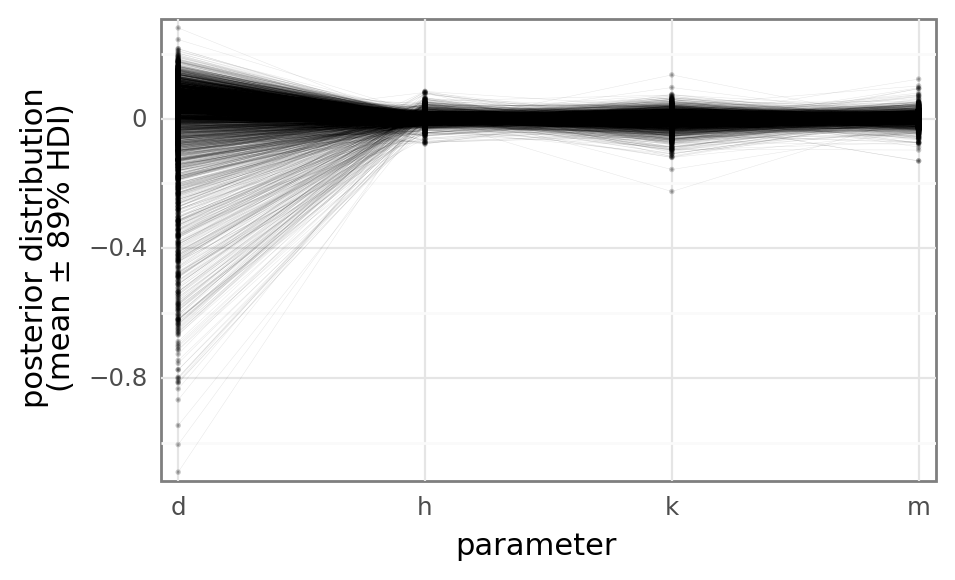

<ggplot: (352826353)>

In [33]:
(
    gg.ggplot(gene_var_post, gg.aes(x="param_name", y="mean"))
    + gg.geom_line(gg.aes(group="lineage + hugo_symbol"), alpha=0.1, size=0.1)
    + gg.geom_point(size=0.1, alpha=0.2)
    + gg.scale_x_discrete(expand=(0, 0.07))
    + gg.scale_y_continuous(expand=((0.02, 0)))
    + gg.theme(figure_size=(5, 3))
    + gg.labs(x="parameter", y=post_y_lbl)
)

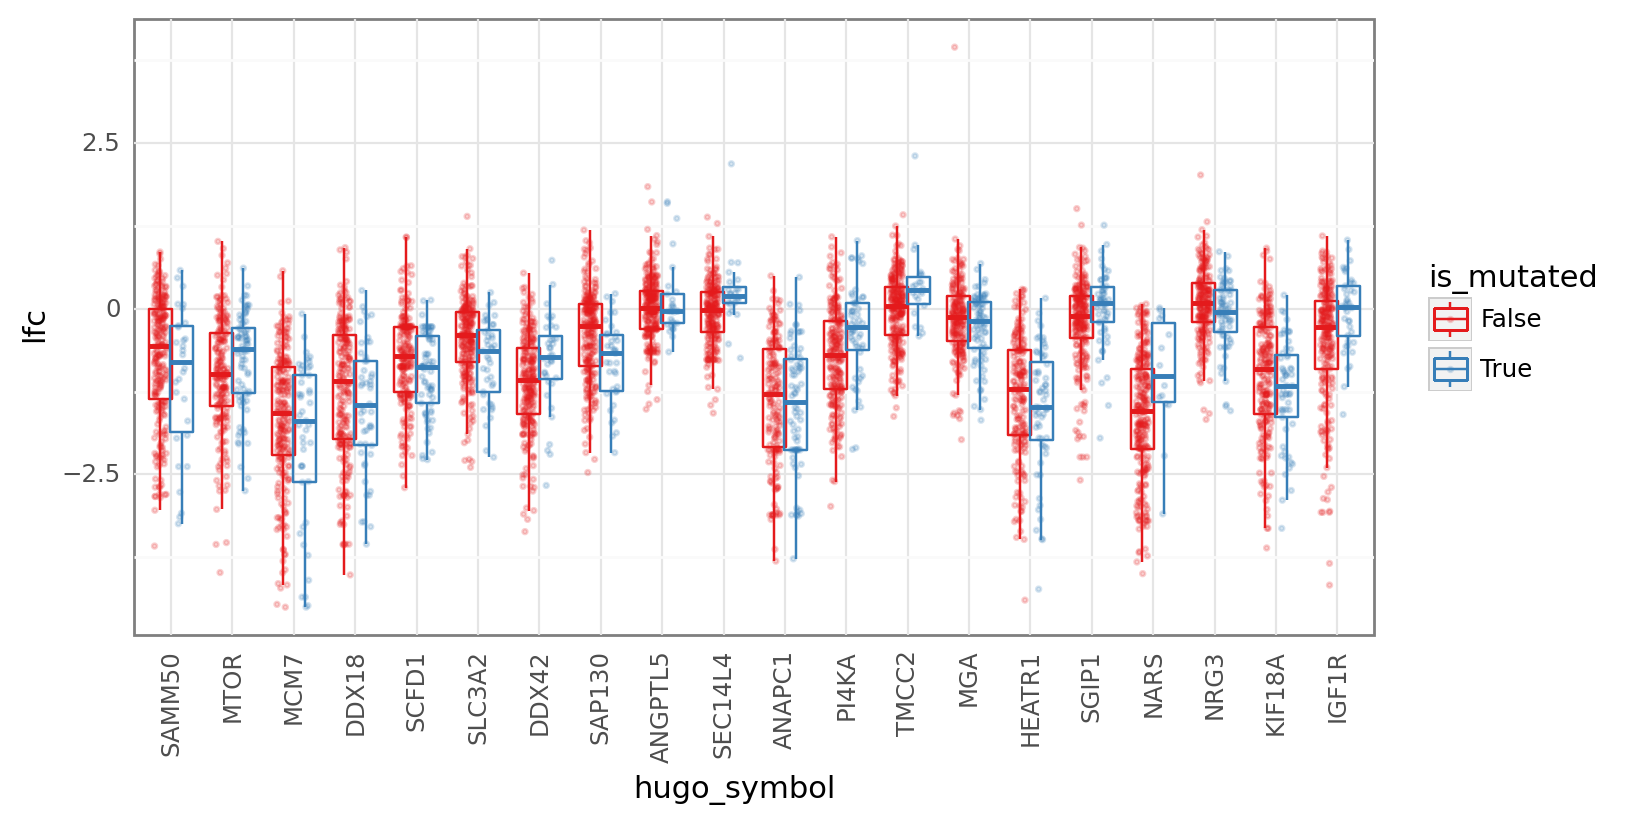

<ggplot: (354661078)>

In [34]:
pos = gg.position_dodge(width=0.7)
jpos = gg.position_jitterdodge(jitter_width=0.2, jitter_height=0, dodge_width=0.7)

(
    gg.ggplot(
        valid_counts_data.filter_column_isin(
            "hugo_symbol", m_post_nonzero_hdi.hugo_symbol
        ).query("lineage == 'colorectal'"),
        gg.aes(x="hugo_symbol", y="lfc", color="is_mutated"),
    )
    + gg.geom_point(size=0.5, position=jpos, alpha=0.2)
    + gg.geom_boxplot(outlier_alpha=0, position=pos, alpha=0)
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.theme(figure_size=(8, 4), axis_text_x=gg.element_text(angle=90))
)

### Looking at specific gene effects

In [35]:
GOI = "SCFD1"

gene_post = gene_var_post.query(f"hugo_symbol == '{GOI}'")
gene_post

,parameter,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,param_name,hugo_symbol,lineage
902,"d[SCFD1, colorectal]",-0.602,0.097,-0.751,-0.445,0.002,0.001,3771.0,2372.0,1.0,d,SCFD1,colorectal
903,"d[SCFD1, bone]",-0.477,0.087,-0.615,-0.342,0.001,0.001,4551.0,2419.0,1.0,d,SCFD1,bone
4902,"k[SCFD1, colorectal]",-0.002,0.036,-0.062,0.052,0.001,0.001,3132.0,1426.0,1.0,k,SCFD1,colorectal
4903,"k[SCFD1, bone]",-0.073,0.029,-0.117,-0.024,0.001,0.000,3075.0,2039.0,1.0,k,SCFD1,bone
8902,"m[SCFD1, colorectal]",-0.131,0.042,-0.196,-0.061,0.001,0.001,2909.0,2036.0,1.0,m,SCFD1,colorectal
8903,"m[SCFD1, bone]",0.009,0.048,-0.065,0.091,0.001,0.001,3111.0,1384.0,1.0,m,SCFD1,bone
451,h[SCFD1],0.043,0.016,0.019,0.068,0.000,0.000,3066.0,1965.0,1.0,h,SCFD1,bone
451,h[SCFD1],0.043,0.016,0.019,0.068,0.000,0.000,3066.0,1965.0,1.0,h,SCFD1,colorectal


In [36]:
gene_counts_data = valid_counts_data.query(f"hugo_symbol == '{GOI}'").reset_index(
    drop=True
)
lineages = valid_counts_data.lineage.cat.categories

cn_vals = np.linspace(-2.5, 2.5, 25)

rna_vals = gene_counts_data.log_rna_expr.values
rna_vals = np.linspace(min(rna_vals), max(rna_vals), 20)


gene_pred_df = pd.DataFrame(
    product(lineages, cn_vals, rna_vals, [True, False]),
    columns=["lineage", "copy_number_z_gene", "log_rna_expr", "is_mutated"],
).assign(hugo_symbol=GOI)
gene_pred_df.head(5)

,lineage,copy_number_z_gene,log_rna_expr,is_mutated,hugo_symbol
0,colorectal,-2.5,0.000000,True,SCFD1
1,colorectal,-2.5,0.000000,False,SCFD1
2,colorectal,-2.5,0.110673,True,SCFD1
3,colorectal,-2.5,0.110673,False,SCFD1
4,colorectal,-2.5,0.221347,True,SCFD1


In [37]:
gene_pred_df.shape

(2000, 5)

In [38]:
def _get_param_post(gene_post_df: pd.DataFrame, param: str) -> pd.DataFrame:
    return gene_post_df.query(f"param_name == '{param}'")[
        ["mean", "hdi_5.5%", "hdi_94.5%", "lineage"]
    ].rename(
        columns={
            "mean": f"{param}_mean",
            "hdi_5.5%": f"{param}_hdi_low",
            "hdi_94.5%": f"{param}_hdi_high",
        }
    )


gene_d = _get_param_post(gene_post, "d")
gene_h = _get_param_post(gene_post, "h")
gene_k = _get_param_post(gene_post, "k")
gene_m = _get_param_post(gene_post, "m")

for param_df in [gene_d, gene_h, gene_k, gene_m]:
    gene_pred_df = gene_pred_df.merge(param_df, on="lineage")

gene_pred_df.head(5)

,lineage,copy_number_z_gene,log_rna_expr,is_mutated,hugo_symbol,d_mean,d_hdi_low,d_hdi_high,h_mean,h_hdi_low,h_hdi_high,k_mean,k_hdi_low,k_hdi_high,m_mean,m_hdi_low,m_hdi_high
0,colorectal,-2.5,0.000000,True,SCFD1,-0.602,-0.751,-0.445,0.043,0.019,0.068,-0.002,-0.062,0.052,-0.131,-0.196,-0.061
1,colorectal,-2.5,0.000000,False,SCFD1,-0.602,-0.751,-0.445,0.043,0.019,0.068,-0.002,-0.062,0.052,-0.131,-0.196,-0.061
2,colorectal,-2.5,0.110673,True,SCFD1,-0.602,-0.751,-0.445,0.043,0.019,0.068,-0.002,-0.062,0.052,-0.131,-0.196,-0.061
3,colorectal,-2.5,0.110673,False,SCFD1,-0.602,-0.751,-0.445,0.043,0.019,0.068,-0.002,-0.062,0.052,-0.131,-0.196,-0.061
4,colorectal,-2.5,0.221347,True,SCFD1,-0.602,-0.751,-0.445,0.043,0.019,0.068,-0.002,-0.062,0.052,-0.131,-0.196,-0.061


In [39]:
gene_pred_df["gene_effect"] = (
    gene_pred_df.d_mean
    + gene_pred_df.h_mean * gene_pred_df.copy_number_z_gene
    + gene_pred_df.k_mean * gene_pred_df.log_rna_expr
    + gene_pred_df.m_mean * gene_pred_df.is_mutated.astype("int")
)

gene_pred_df["gene_effect_hdi_low"] = (
    gene_pred_df.d_hdi_low
    + gene_pred_df.h_hdi_low * gene_pred_df.copy_number_z_gene
    + gene_pred_df.k_hdi_low * gene_pred_df.log_rna_expr
    + gene_pred_df.m_hdi_low * gene_pred_df.is_mutated.astype("int")
)


gene_pred_df["gene_effect_hdi_high"] = (
    gene_pred_df.d_hdi_high
    + gene_pred_df.h_hdi_high * gene_pred_df.copy_number_z_gene
    + gene_pred_df.k_hdi_high * gene_pred_df.log_rna_expr
    + gene_pred_df.m_hdi_high * gene_pred_df.is_mutated.astype("int")
)

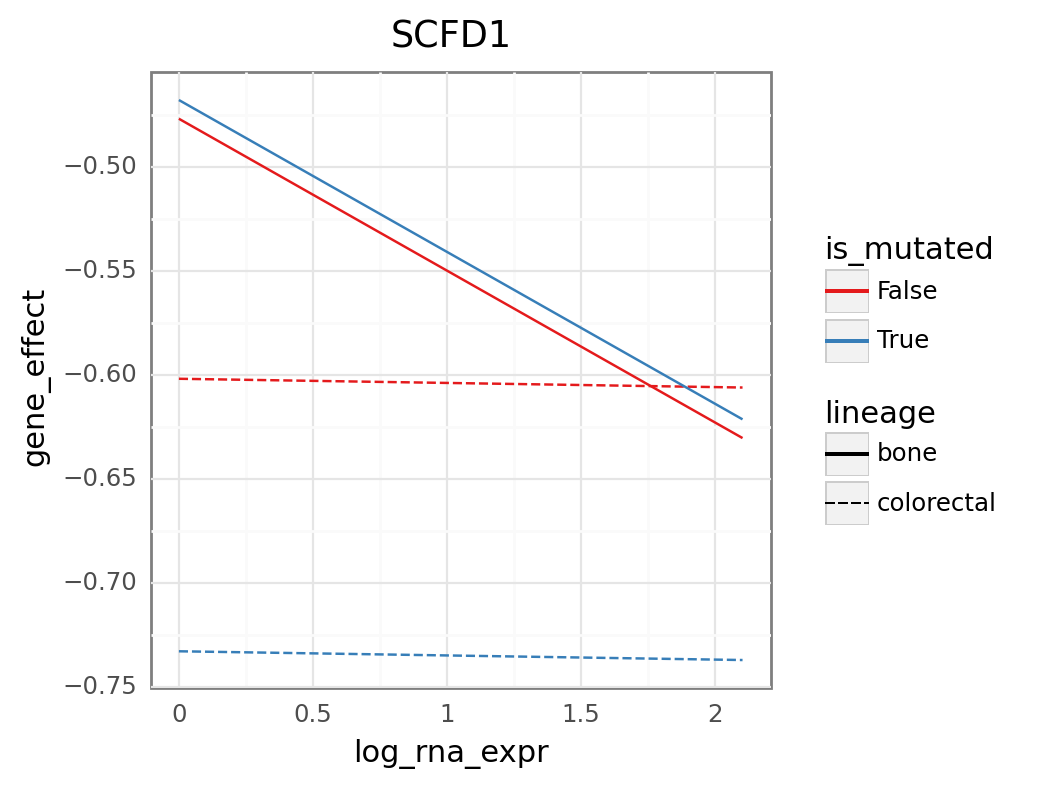

<ggplot: (349583177)>

In [40]:
(
    gg.ggplot(
        gene_pred_df.query("copy_number_z_gene == 0.0"),
        gg.aes(x="log_rna_expr", y="gene_effect"),
    )
    + gg.geom_line(gg.aes(color="is_mutated", linetype="lineage"))
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.theme(figure_size=(4, 4))
    + gg.labs(title=GOI)
)

## Posterior predictions

In [41]:
def _hdi(x: pd.Series) -> np.ndarray:
    return az.hdi(x.values.flatten(), hdi_prob=HDI_PROB)


grouped_ppc = hnb_post_pred.groupby(["ct_final_dim_0"])["ct_final"]
ppc_mean = grouped_ppc.mean().reset_index(drop=True)
ppc_hdi = np.asarray([x.tolist() for x in grouped_ppc.apply(_hdi)])

In [42]:
keep_cols = [
    "sgrna",
    "lfc",
    "hugo_symbol",
    "depmap_id",
    "counts_final",
    "counts_initial_adj",
    "is_mutated",
    "lineage",
    "copy_number",
    "z_cn_gene",
    "z_cn_cell_line",
    "log_rna_expr",
]

hnb_ppc_summary = (
    valid_counts_data[keep_cols]
    .assign(
        ppc_mean=ppc_mean.values, ppc_hdi_low=ppc_hdi[:, 0], ppc_hdi_high=ppc_hdi[:, 1]
    )
    .assign(ppc_resid=lambda d: d.counts_final - d.ppc_mean)
)

In [43]:
N_SUBS = 20000

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/facets/facet.py:487: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


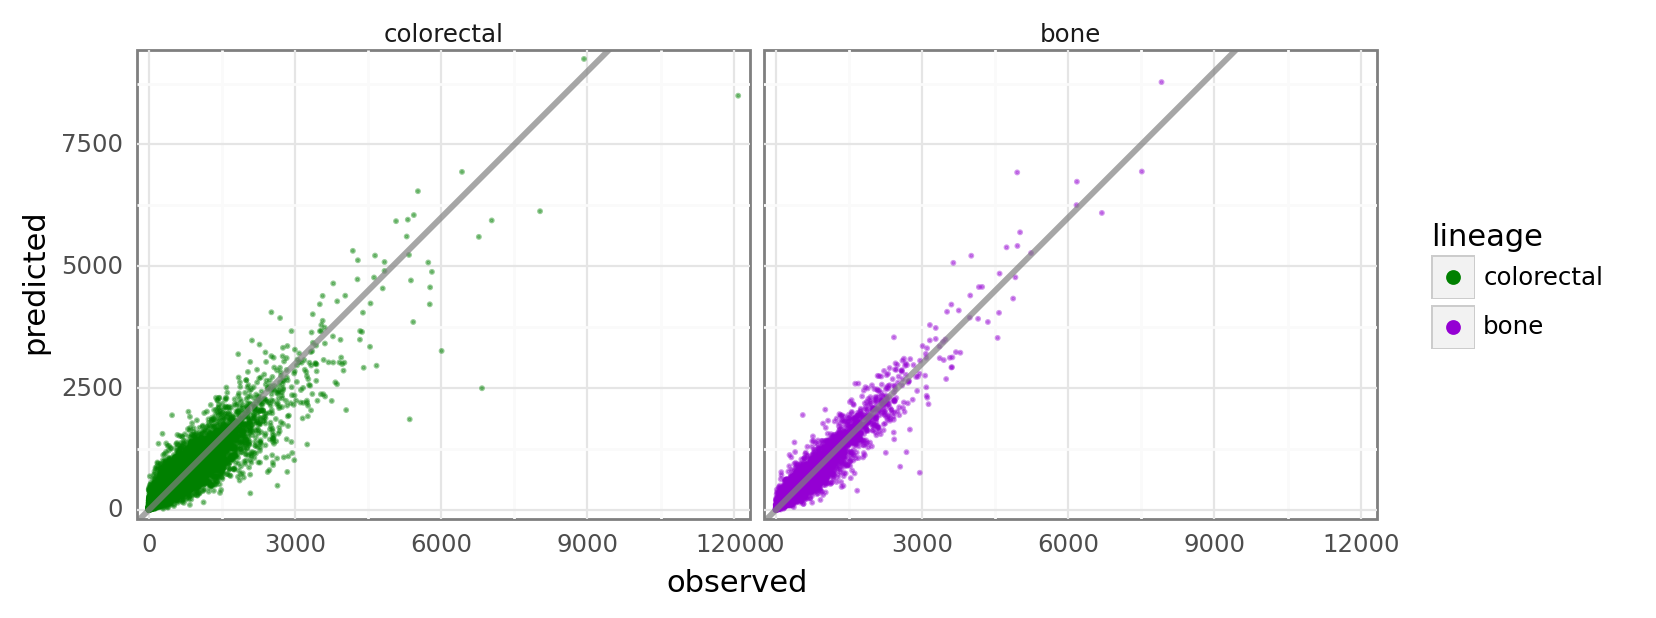

<ggplot: (354753365)>

In [44]:
(
    gg.ggplot(
        hnb_ppc_summary.sample(n=N_SUBS),
        gg.aes(x="counts_final", y="ppc_mean", color="lineage"),
    )
    + gg.facet_wrap("~lineage", nrow=1)
    + gg.geom_point(size=0.2, alpha=0.4)
    + gg.geom_abline(slope=1, intercept=0, color="gray", size=1.2, alpha=0.7)
    + gg.scale_x_continuous(expand=(0.02, 0))
    + gg.scale_y_continuous(expand=(0.02, 0))
    + gg.scale_color_manual(
        lineage_pal, guide=gg.guide_legend(override_aes={"size": 2, "alpha": 1})
    )
    + gg.coord_fixed()
    + gg.theme(figure_size=(8, 4))
    + gg.labs(x="observed", y="predicted")
)

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/facets/facet.py:487: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


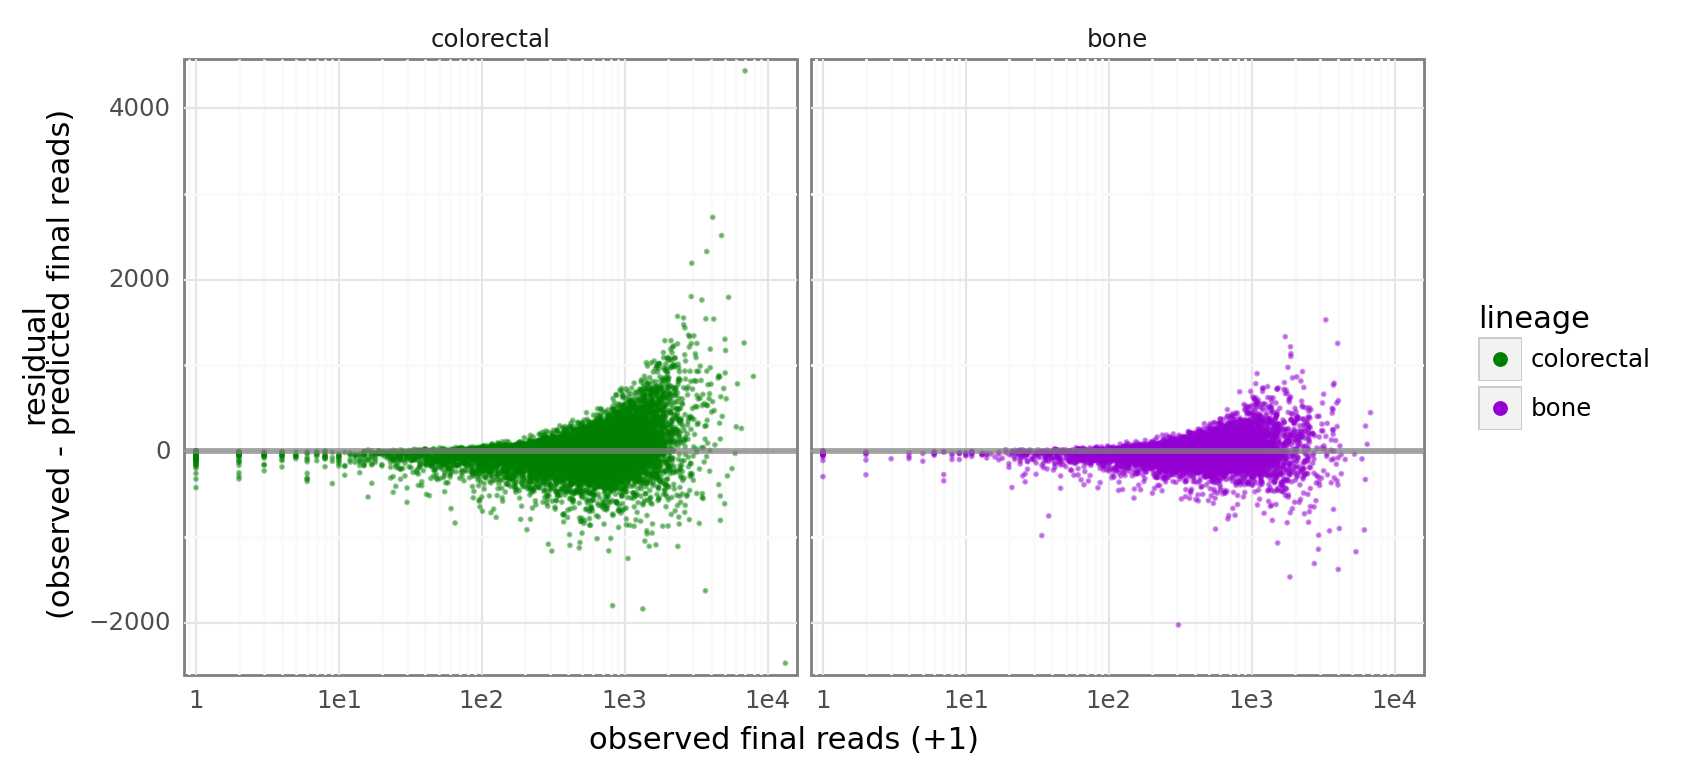

<ggplot: (350213970)>

In [45]:
(
    gg.ggplot(
        hnb_ppc_summary.sample(n=N_SUBS),
        gg.aes(x="counts_final+1", y="ppc_resid", color="lineage"),
    )
    + gg.facet_wrap("~lineage", nrow=1)
    + gg.geom_point(size=0.2, alpha=0.4)
    + gg.geom_hline(yintercept=0, color="gray", size=1.2, alpha=0.7)
    + gg.scale_x_log10(expand=(0.02, 0))
    + gg.scale_y_continuous(expand=(0.02, 0))
    + gg.scale_color_manual(
        lineage_pal, guide=gg.guide_legend(override_aes={"size": 2, "alpha": 1})
    )
    + gg.theme(figure_size=(8, 4))
    + gg.labs(
        x="observed final reads (+1)", y="residual\n(observed - predicted final reads)"
    )
)

In [46]:
plot_x = {
    "log RNA expression": "log_rna_expr",
    "copy number (gene z-scaled)": "z_cn_gene",
    "copy number (cell line z-scaled)": "z_cn_cell_line",
    "copy number": "copy_number",
}

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/facets/facet.py:487: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


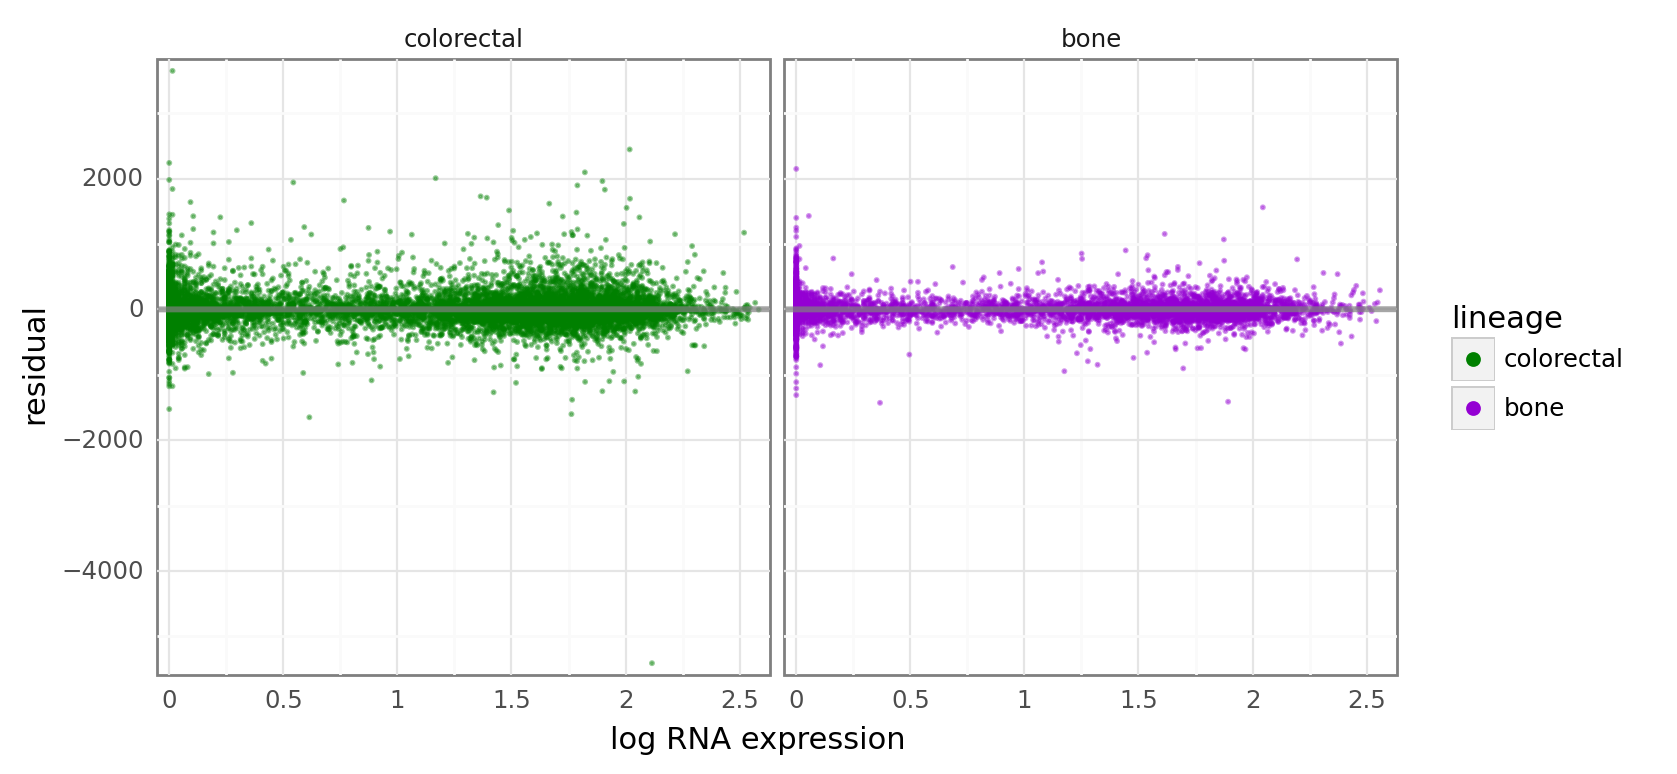

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/facets/facet.py:487: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


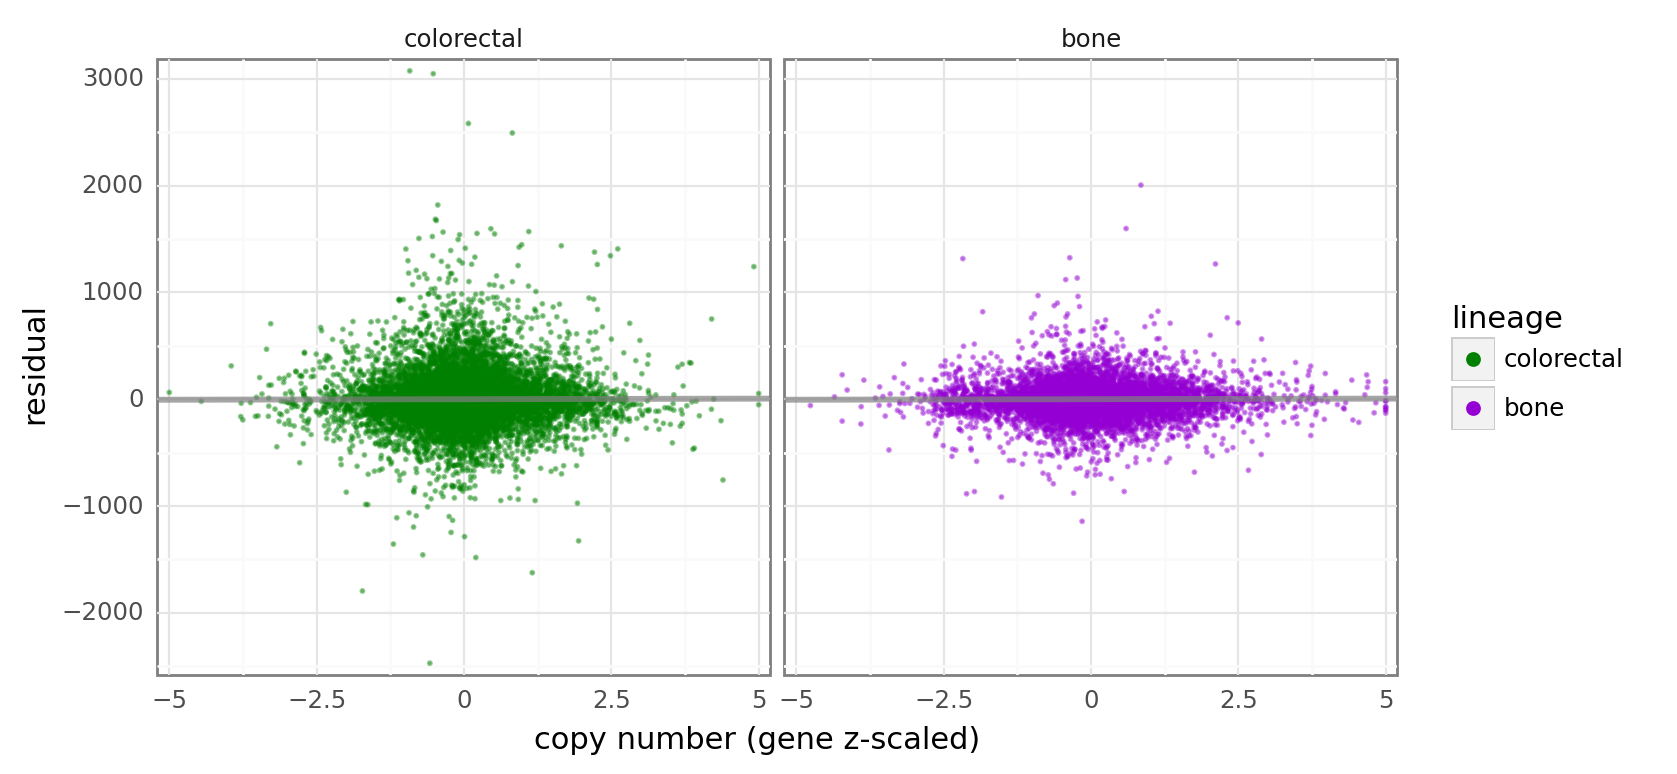

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/facets/facet.py:487: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


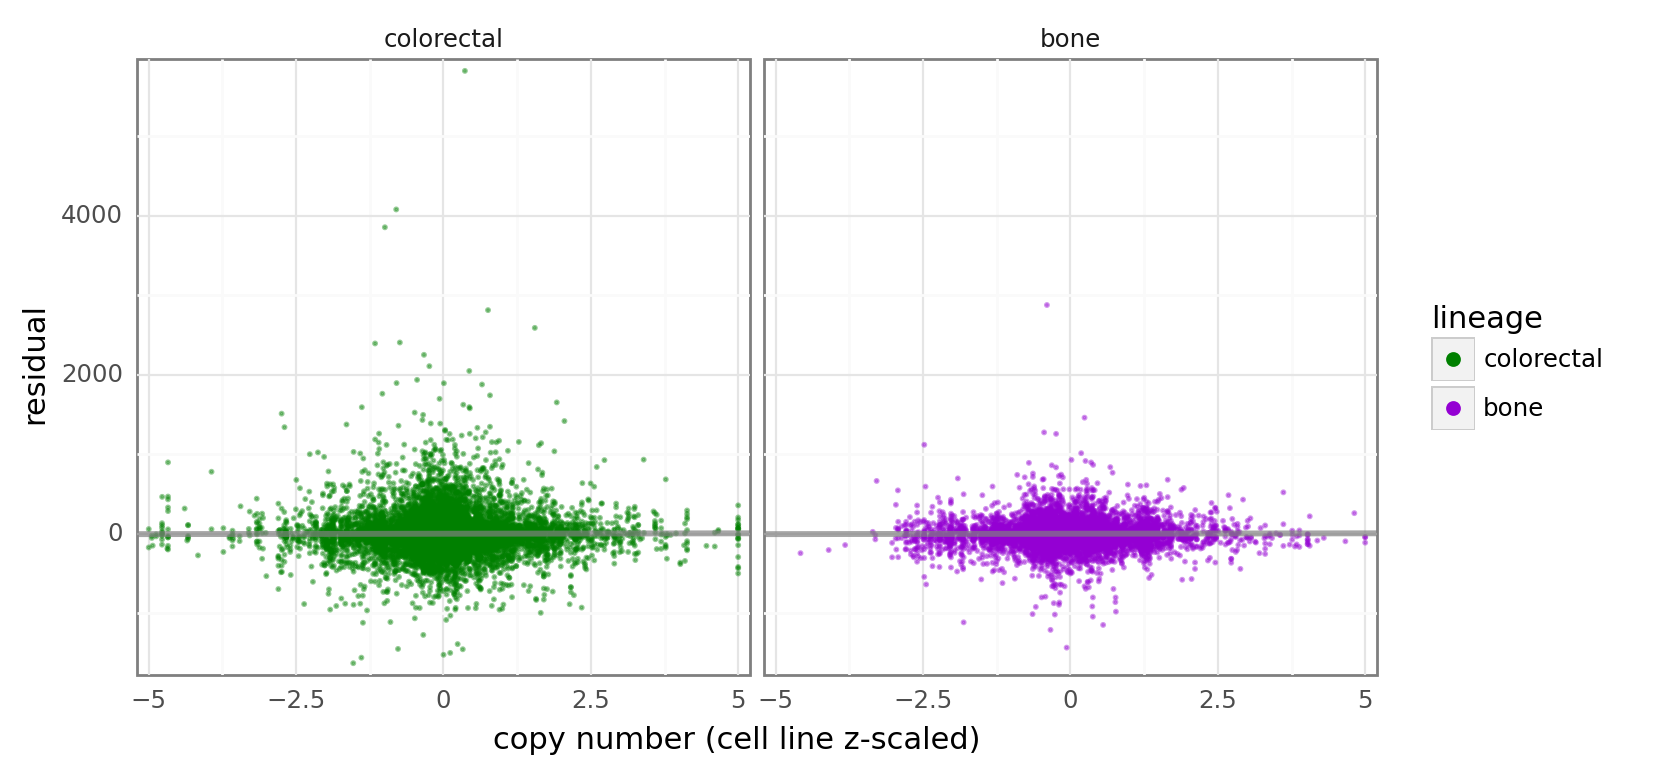

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/facets/facet.py:487: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


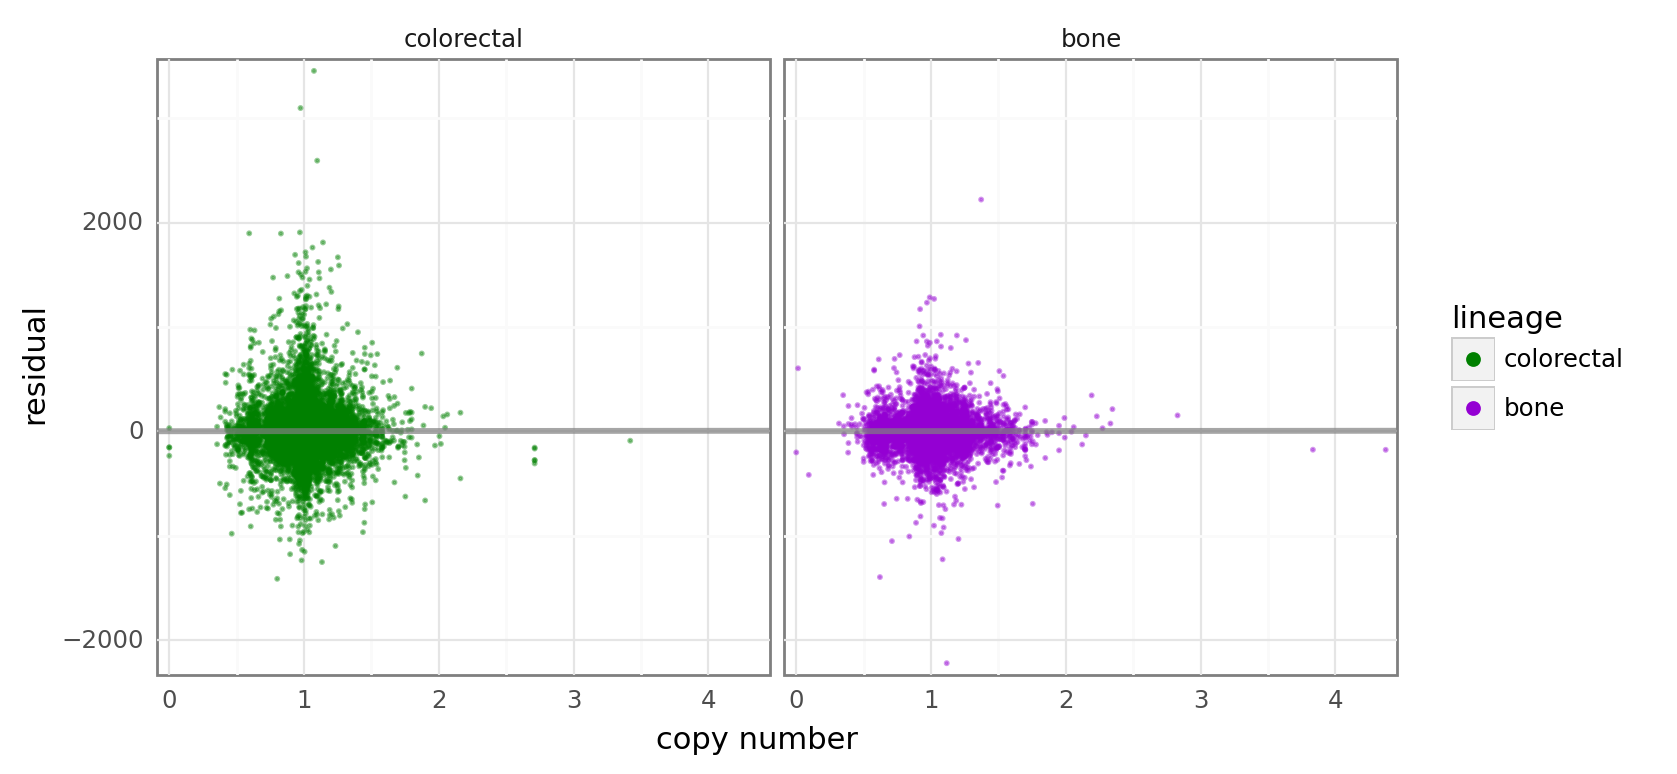

In [47]:
for x_lbl, x_val in plot_x.items():
    p = (
        gg.ggplot(
            hnb_ppc_summary.sample(n=N_SUBS),
            gg.aes(x=x_val, y="ppc_resid", color="lineage"),
        )
        + gg.facet_wrap("~lineage", nrow=1)
        + gg.geom_point(size=0.2, alpha=0.4)
        + gg.geom_abline(slope=1, intercept=0, color="gray", size=1.2, alpha=0.7)
        + gg.scale_x_continuous(expand=(0.02, 0))
        + gg.scale_y_continuous(expand=(0.02, 0))
        + gg.scale_color_manual(
            lineage_pal, guide=gg.guide_legend(override_aes={"size": 2, "alpha": 1})
        )
        + gg.theme(figure_size=(8, 4))
        + gg.labs(x=x_lbl, y="residual")
    )
    print(p)

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/geoms/geom_violin.py:49: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/facets/facet.py:487: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


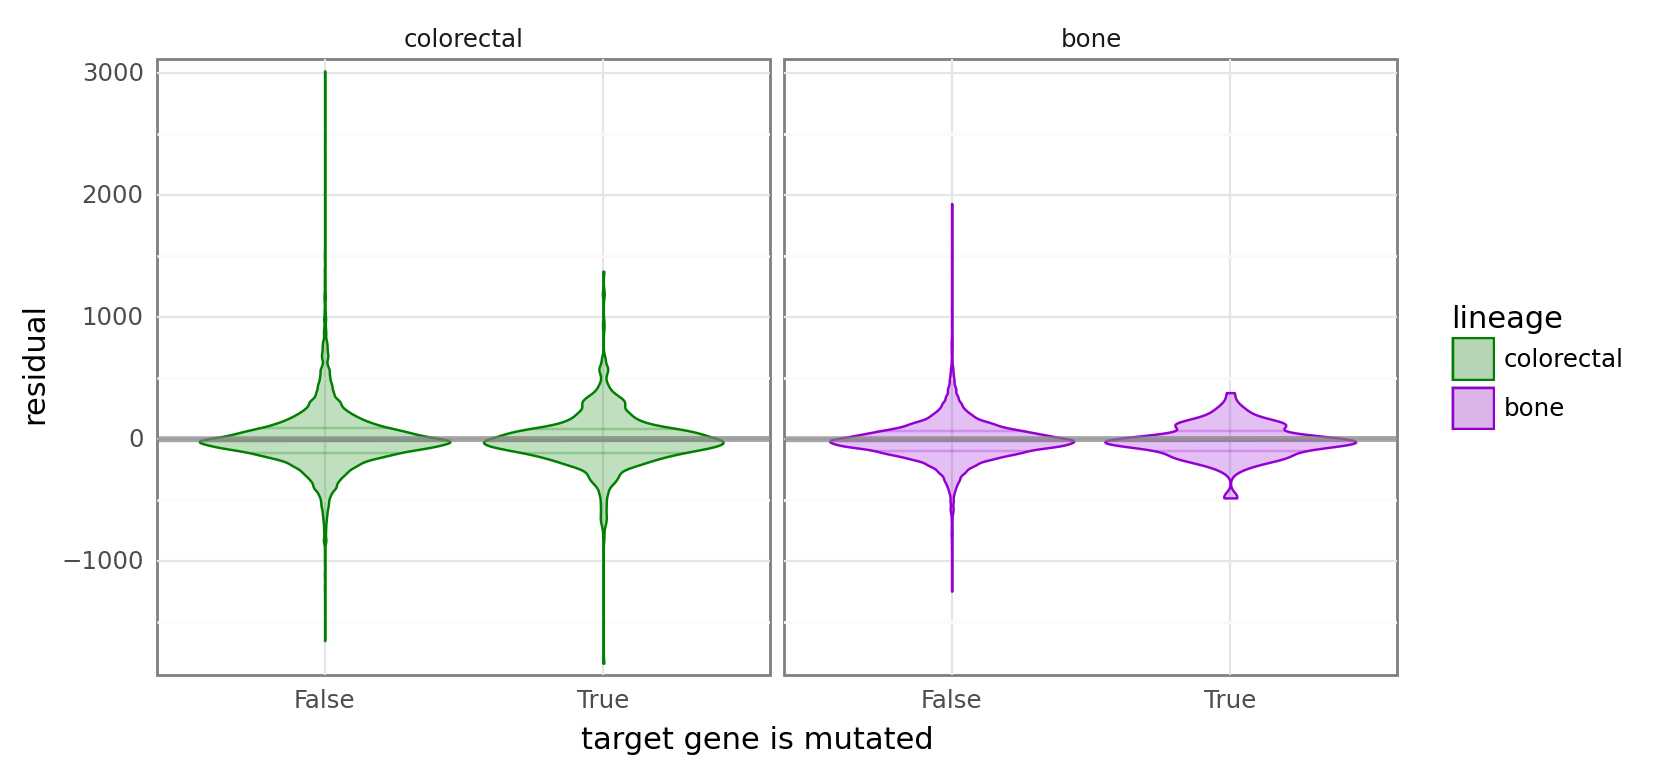

<ggplot: (350797138)>

In [48]:
(
    gg.ggplot(
        hnb_ppc_summary.sample(n=N_SUBS),
        gg.aes(x="is_mutated", y="ppc_resid", color="lineage", fill="lineage"),
    )
    + gg.facet_wrap("~lineage", nrow=1)
    + gg.geom_violin(alpha=0.25, draw_quantiles=(0.25, 0.5, 0.75))
    + gg.geom_abline(slope=1, intercept=0, color="gray", size=1.2, alpha=0.7)
    + gg.scale_y_continuous(expand=(0.02, 0))
    + gg.scale_color_manual(lineage_pal)
    + gg.scale_fill_manual(lineage_pal)
    + gg.theme(figure_size=(8, 4))
    + gg.labs(x="target gene is mutated", y="residual")
)

---

In [49]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 4.72 minutes


In [50]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-03-24

Python implementation: CPython
Python version       : 3.9.9
IPython version      : 8.0.1

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 21.4.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: JHCookMac

Git branch: add-nb-model

numpy     : 1.22.2
re        : 2.2.1
pymc      : 4.0.0b2
arviz     : 0.11.4
pandas    : 1.4.1
plotnine  : 0.8.0
seaborn   : 0.11.2
matplotlib: 3.5.1

